In [85]:
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt
from libs.XY_model import XYSystem
from tqdm import tqdm

In [86]:
def get_curl(x):    
    N = x.shape[0]
    curl = []
    ux = cos(x)
    uy = sin(x)
    for i in range(N):
        cu = []
        for j in range(N):
            c = (ux[i, j] - ux[(i+1)%N, (j+1)%N]) + (uy[(i+1)%N, j] - uy[i, (j+1)%N]) 
            c += np.sum(ux[(i-1)%N, (j-1)%N : (j+3)%N]) - \
                    np.sum(ux[(i+2)%N, (j-1)%N : (j+3)%N]) + \
                    \
                    np.sum(uy[(i-1)%N : (i+3)%N, (j-1)%N]) - \
                    np.sum(uy[(i-1)%N : (i+3)%N, (j+2)%N])
            
            c += np.sum(ux[(i-2)%N, (j-2)%N : (j+4)%N]) - \
                    np.sum(ux[(i+3)%N, (j-2)%N : (j+4)%N]) + \
                    \
                    np.sum(uy[(i-2)%N : (i+4)%N, (j-2)%N]) - \
                    np.sum(uy[(i-2)%N : (i+4)%N, (j+3)%N])
                    
            #   c += np.sum(ux[(i-3)%N, (j-3)%N : (j+5)%N]) - \
            #        np.sum(ux[(i+4)%N, (j-3)%N : (j+5)%N]) + \
            #        \
            #        np.sum(uy[(i-3)%N : (i+5)%N, (j-3)%N]) - \
            #        np.sum(uy[(i-3)%N : (i+5)%N, (j+4)%N]) / 49
            cu.append(c)
        curl.append(cu)
             
    curl = np.array(curl)
    return curl

In [87]:
def find_local_ext(x):
    N = x.shape[0]
    maxima = []
    maxim_cu = np.zeros([N, N])
    minima = []
    minim_cu = np.zeros([N, N])
    up_th = np.max(x) * 0.6
    down_th = np.min(x) * 0.6
    for i in range(N):
        for j in range(N):
            if(x[i, j] >= up_th):
                maxima.append([i, j])
                maxim_cu[i, j] = x[i, j]
            if(x[i, j] <= down_th):
                minima.append([i, j])
                minim_cu[i, j] = x[i, j]
    return np.array(maxima), np.array(minima), maxim_cu, minim_cu

In [88]:
def find_distribution(cu, min_loc, max_loc, max_dist, bins = 200):
    p = np.zeros(bins)
    c = np.zeros(bins)
    dr = (max_dist  / (bins - 1))
    for i in range(max_loc.shape[0]):
        for j in range(min_loc.shape[0]):
            d = ((max_loc[i, 0] - min_loc[j, 0])**2 + (max_loc[i, 1] - min_loc[j, 1])**2)**(0.5)
            r = (int) (d / dr)
            p[r] += 1
            c[r] += (cu[max_loc[i, 0], max_loc[i, 1]] * cu[min_loc[j, 0], min_loc[j, 1]])
    p /= (sum(p) * dr)
    c /= (sum(c) * dr)
    return p, c

In [89]:
def list2matrix(S):
        N=int(np.size(S))
        L = int(np.sqrt(N))
        S=np.reshape(S,(L,L))
        return S

In [90]:
def plot_heatmap(spin_config, curl, temp, name = 'result', heat = True, just_heat = False):
    N = spin_config.shape[0]
    plt.figure(figsize=(4,4),dpi=800, facecolor='white')
    if(heat):
        plt.imshow(curl)
        plt.colorbar()
    if(just_heat):
        plt.imshow(curl)
        plt.colorbar()
        plt.savefig(f'./images/{name}.png', dpi = 800)
        plt.close()
        return
    X, Y = np.meshgrid(np.arange(0,N),np.arange(0, N))
    U = np.cos(spin_config)
    V = np.sin(spin_config)
    Q = plt.quiver(X, Y, U, V, units='width')
    qk = plt.quiverkey(Q, 0.1, 0.1, 1, r'$spin$', labelpos='E',
                coordinates='figure')
    plt.title('T=%.2f'%temp+', #spins='+str(N)+'x'+str(N))
    plt.savefig(f'./images/{name}.png', dpi = 800)
    plt.close()

In [91]:
def do_monte_carlo(temp, N):
    xy = XYSystem(temperature = temp, width = N)
    xy.equilibrate(show=False)
    return list2matrix(xy.spin_config)

In [92]:
temp = [0.05, 0.2, 0.6, 0.9, 1.5]
N = 64
ensemble = 1000
bins = 500
P_r = []
C_r = []

In [93]:
for i in tqdm(range(len(temp))):
    p = np.zeros(bins)
    c = np.zeros(bins)
    for e in range(1, ensemble+1):
        x = do_monte_carlo(temp[i], N)
        cu = get_curl(x)
        maxima, minima, max_cu, min_cu = find_local_ext(cu)
        pp, cc = find_distribution(cu, minima, maxima, ((N**2) + (N**2))**(0.5), bins)
        p += pp
        c += cc
        # if(e == 1):
        #     plot_heatmap(x, cu, temp[i], f'mix_{temp[i]}_{N}')
        #     plot_heatmap(x, max_cu, temp[i], f'maxima_{temp[i]}_{N}', False, True)
        #     plot_heatmap(x, min_cu, temp[i], f'minima_{temp[i]}_{N}', False, True)
        #     plot_heatmap(x, cu, temp[i], f'vec_{temp[i]}_{N}', False)
        #     plot_heatmap(x, cu, temp[i], f'curl_{temp[i]}_{N}', False, True)

    p /= ensemble
    c /= ensemble
    P_r.append(p)
    C_r.append(c)
        

  0%|          | 0/5 [01:18<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
p_r = np.array(P_r)
c_r = np.array(C_r)

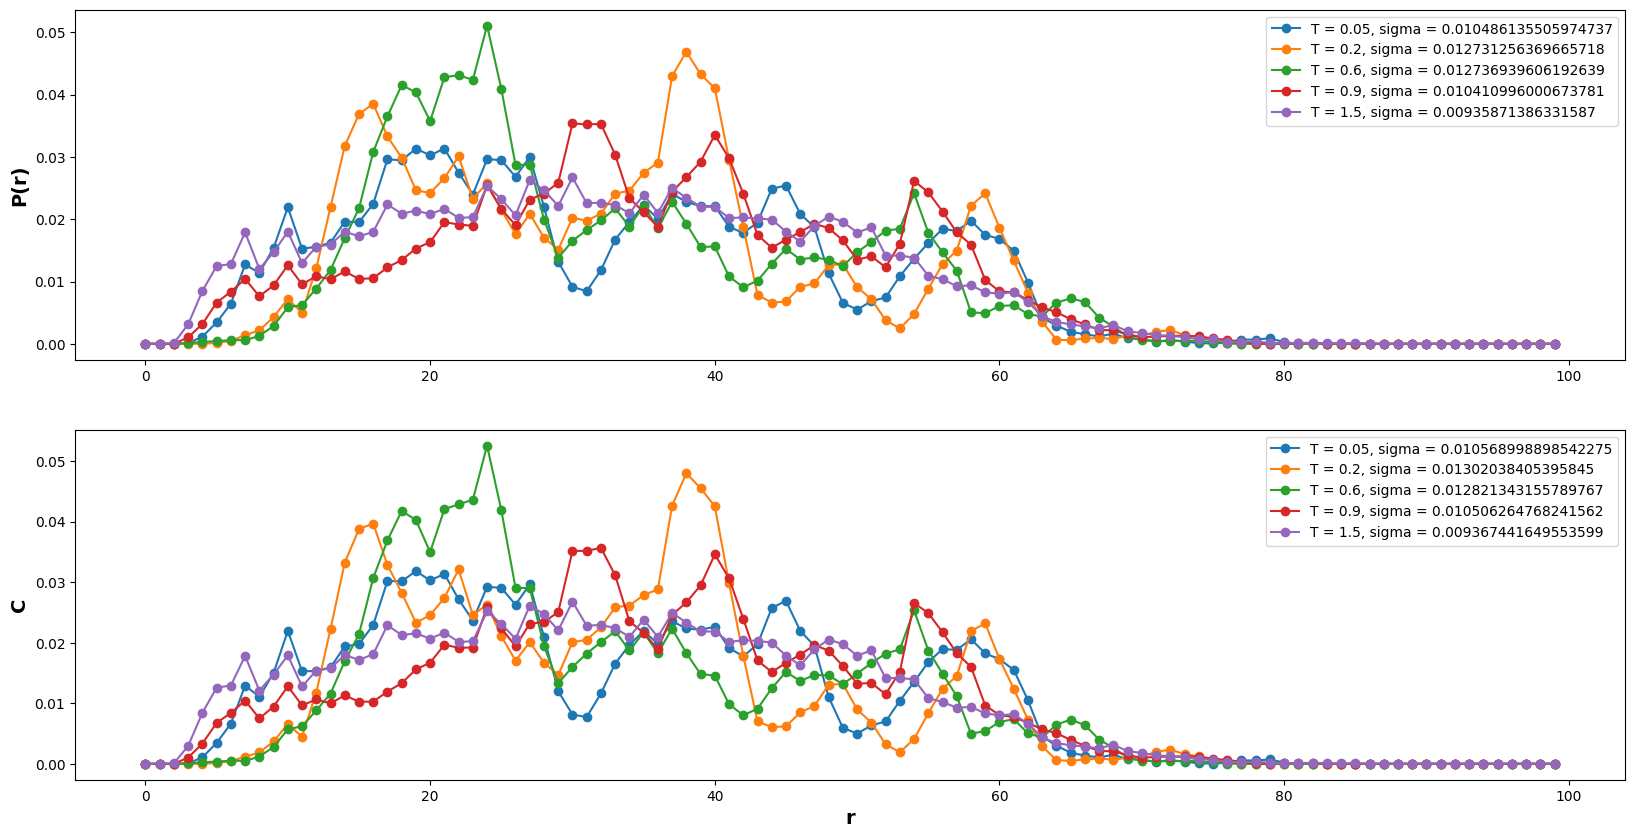

In [ ]:
fig1, ax1 = plt.subplots(2, figsize=(20, 10), dpi = 100)

for i in range(len(temp)):
    ax1[0].plot(np.linspace(0, (N**2 + N**2)**0.5, bins), p_r[i, :], '-o',label = f'T = {temp[i]}')
    ax1[1].plot(np.linspace(0, (N**2 + N**2)**0.5, bins), c_r[i, :], '-o',label = f'T = {temp[i]}')

ax1[0].set_ylabel("P(r)", fontsize = 14, fontweight = 'bold')
ax1[0].legend()

ax1[1].set_ylabel("C", fontsize = 14, fontweight = 'bold')
ax1[1].set_xlabel("r", fontsize = 14, fontweight = 'bold')
ax1[1].legend()
fig1.savefig('./images/pr.png', dpi = 100);